# Migration simulation in EU

### Multipliers
Each element included in happiness is multiply by corresponding multiplier. At the end all elements are summed up.

In [1]:
MULTIPLIER_INTEGRATION_WITH_IMMIGRANTS = 0.1

MULTIPLIER_RACE_1ST = 0.3
MULTIPLIER_RACE_2ND = 0.2
MULTIPLIER_RACE_3RD = 0.1

MULTIPLIER_RELIGIOUS_DENOMINATION_1ST = 0.3
MULTIPLIER_RELIGIOUS_DENOMINATION_2ND = 0.2
MULTIPLIER_RELIGIOUS_DENOMINATION_3RD = 0.1

MULTIPLIER_SENSE_OF_COMFORT = 0.1

MULTIPLIER_MIGRATION_INTO_OUR_COUNTRY = 0.1

### Neighboring countries
Agent can migrate only to neighboring countries.

In [2]:
NEIGHBORING_COUNTRIES = {
    'Austria': ['Germany', 'Italy', 'Slovenia', 'Hungary', 'Slovakia', 'Czech Republic'],
    'Belgium': ['France', 'Germany', 'Luxemburg', 'Netherlands', 'Ireland', 'United Kingdom'],
    'Bulgaria': ['Greece', 'Romania'],
    'Croatia': ['Hungary', 'Slovenia'],
    'Cyprus': ['Greece'],
    'Czech Republic': ['Slovakia', 'Poland', 'Germany', 'Austria'],
    'Denmark': ['Germany', 'Sweden', 'United Kingdom'],
    'Estonia': ['Sweden', 'Finland', 'Latvia'],
    'Finland': ['Sweden', 'Estonia'],
    'France': ['Belgium', 'Luxemburg', 'Germany', 'Italy', 'Spain', 'United Kingdom', 'Netherlands'],
    'Greece': ['Bulgaria','Cyprus', 'Italy'],
    'Spain': ['Portugal', 'France'],
    'Ireland': ['United Kingdom', 'Netherlands', 'Belgium'],
    'Lithuania': ['Latvia', 'Poland', 'Sweden'],
    'Luxemburg': ['Germany', 'Belgium', 'France'],
    'Latvia': ['Estonia', 'Lithuania', 'Sweden'],
    'Malta': ['Italy'],
    'Netherlands': ['Germany', 'Belgium', 'France', 'United Kingdom', 'Ireland'],
    'Germany': ['Denmark', 'Poland', 'Czech Republic', 'Austria', 'France', 'Luxemburg', 'Belgium', 'Netherlands', 'Sweden', 'United Kingdom'],
    'Poland': ['Germany', 'Lithuania', 'Slovakia', 'Czech Republic', 'Sweden'],
    'Portugal': ['Spain'],
    'Romania': ['Bulgaria', 'Hungary'],
    'Slovakia': ['Czech Republic', 'Austria', 'Hungary', 'Poland'],
    'Slovenia': ['Austria', 'Croatia', 'Hungary', 'Italy'],
    'Sweden': ['Denmark', 'Germany', 'Poland', 'Lithuania', 'Latvia', 'Estonia'],
    'Hungary': ['Slovakia', 'Romania', 'Croatia', 'Slovenia', 'Austria'],
    'United Kingdom': ['Belgium', 'Denmark', 'France', 'Germany', 'Netherlands', 'Ireland'],
    'Italy': ['Austria', 'France', 'Slovenia', 'Greece', 'Malta']
}

Choosing next country is based on probability which depends on happiness values.
Sometimes happiness can be lower than 0, so I decided to use sigmoid function to change them to values from [0-1] interval.

In [3]:
import numpy as np


def sigmoid(n):
    return 1 / (1 + np.exp(-n))

In [4]:
from mesa import Agent


class Person(Agent):

    def __init__(self, model, unique_id, origin_country, current_country, race, religious_denomination,
                 likely_to_travel, conditions, neigboring_countries=NEIGHBORING_COUNTRIES):
        super().__init__(unique_id, model)
        self.origin_country = origin_country
        self.current_country = current_country
        self.race = race
        self.religious_denomination = religious_denomination
        self.likely_to_travel = likely_to_travel
        self.conditions = conditions
        self.happiness = self._calculate_happiness(self.current_country)
        self.neigboring_countries = neigboring_countries

    def step(self):
        happiness_index = {}
        if self.current_country == self.origin_country:
            happiness_index[self.current_country] = self.likely_to_travel * self.happiness
        else:
            happiness_index[self.current_country] = (1 - self.likely_to_travel) * self.happiness
        for country in self.neigboring_countries.get(self.current_country):
            happiness_country = self._calculate_happiness(country)
            happiness_index[country] = happiness_country

        happiness_probabilities = sigmoid(np.array(list(happiness_index.values())))
        
        next_country = np.random.choice(np.array(list(happiness_index.keys())), 1,
                                        p=happiness_probabilities / np.sum(happiness_probabilities))[0]
        self.current_country = next_country
        self.happiness = happiness_index[next_country]

    def _calculate_happiness(self, country):
        happiness = 0
        happiness += self._calculate_happines_based_on_race(country)
        happiness += self._calculate_happiness_based_on_religious_denomination(country)
        if country != self.origin_country:
            happiness += self._calculate_happiness_based_on_a_sense_of_comfort_with_immigrants(country)
            happiness += self._calculate_happiness_based_on_integration_frequency_with_immigrants(country)
            happiness += self._calculate_happiness_based_on_thoughts_about_migration_into_own_country(country)
        return happiness

    def _calculate_happines_based_on_race(self, country):
        happiness_race = {}
        beggining_of_column_name = 'Would you feel comfortable if one of your children was in a relationship with '
        happiness_race['White'] = self.conditions[beggining_of_column_name + 'a White person?'][country]
        happiness_race['Black'] = self.conditions[beggining_of_column_name + 'a Black person?'][country]
        happiness_race['Asian'] = self.conditions[beggining_of_column_name + 'an Asian person?'][country]
        happiness_race_sorted = sorted(happiness_race, key=happiness_race.get)
        idx = happiness_race_sorted.index(self.race)

        value_for_agents_race = 0
        if self.race == 'White':
            value_for_agents_race = self.conditions[beggining_of_column_name + 'a White person?'][country]
        elif self.race == 'Black':
            value_for_agents_race = self.conditions[beggining_of_column_name + 'a Black person?'][country]
        elif self.race == 'Asian':
            value_for_agents_race = self.conditions[beggining_of_column_name + 'an Asian person?'][country]

        if idx == 0:
            return MULTIPLIER_RACE_1ST * value_for_agents_race
        elif idx == 1:
            return MULTIPLIER_RACE_2ND * value_for_agents_race
        elif idx == 2:
            return MULTIPLIER_RACE_3RD * value_for_agents_race

    def _calculate_happiness_based_on_religious_denomination(self, country):
        happiness_religious_denomination = {}
        beggining_of_column_name = 'Would you feel comfortable if one of your children was in a relationship with a '
        happiness_religious_denomination['Jew'] = self.conditions[beggining_of_column_name + 'Jew?'][country]
        happiness_religious_denomination['Muslim'] = self.conditions[beggining_of_column_name + 'Muslim?'][country]
        happiness_religious_denomination['Christian'] = self.conditions[beggining_of_column_name + 'Christian?'][country]
        happiness_religious_denomination_sorted = sorted(happiness_religious_denomination,
                                                         key=happiness_religious_denomination.get)
        idx = happiness_religious_denomination_sorted.index(self.religious_denomination)

        value_for_agents_religious_denomination = 0
        if self.religious_denomination == 'Jew':
            value_for_agents_religious_denomination = self.conditions[beggining_of_column_name + 'Jew?'][country]
        elif self.religious_denomination == 'Muslim':
            value_for_agents_religious_denomination = self.conditions[beggining_of_column_name + 'Muslim?'][country]
        elif self.religious_denomination == 'Christian':
            value_for_agents_religious_denomination = self.conditions[beggining_of_column_name + 'Christian?'][country]

        if idx == 0:
            return MULTIPLIER_RELIGIOUS_DENOMINATION_1ST * value_for_agents_religious_denomination
        elif idx == 1:
            return MULTIPLIER_RELIGIOUS_DENOMINATION_2ND * value_for_agents_religious_denomination
        elif idx == 2:
            return MULTIPLIER_RELIGIOUS_DENOMINATION_3RD * value_for_agents_religious_denomination

    def _calculate_happiness_based_on_a_sense_of_comfort_with_immigrants(self, country):
        if self.conditions['Feel comfortable with all the social relations'][country] >= \
                self.conditions['Feel uncomfortable with at least one social relation'][country]:
            return MULTIPLIER_SENSE_OF_COMFORT * \
                    self.conditions['Feel comfortable with all the social relations'][country]
        else:
            return -MULTIPLIER_SENSE_OF_COMFORT * \
                   self.conditions['Feel uncomfortable with at least one social relation'][country]

    def _calculate_happiness_based_on_integration_frequency_with_immigrants(self, country):
        if self.conditions['Frequent integration'][country] >= self.conditions['Less frequent integration'][country]:
            return MULTIPLIER_INTEGRATION_WITH_IMMIGRANTS * self.conditions['Frequent integration'][country]
        else:
            return -MULTIPLIER_INTEGRATION_WITH_IMMIGRANTS * self.conditions['Less frequent integration'][country]

    def _calculate_happiness_based_on_thoughts_about_migration_into_own_country(self, country):
        agree = self.conditions['Strongly agree'][country] + self.conditions['Agree'][country]
        disagree = self.conditions['Strongly disagree'][country] + self.conditions['Disagree'][country]
        if agree >= disagree:
            return 2 * MULTIPLIER_MIGRATION_INTO_OUR_COUNTRY * self.conditions['Strongly agree'][
                country] + MULTIPLIER_MIGRATION_INTO_OUR_COUNTRY * self.conditions['Agree'][country]
        else:
            return -(2 * MULTIPLIER_MIGRATION_INTO_OUR_COUNTRY * self.conditions['Strongly disagree'][
                country] + MULTIPLIER_MIGRATION_INTO_OUR_COUNTRY * self.conditions['Disagree'][country])


In [5]:
from mesa import Model
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation


class EUMap(Model):
    def __init__(self, agents_attribute, conditions, agents_count=100000):

        self.schedule = RandomActivation(self)
        probability_country = agents_attribute['Population'] / agents_attribute['Population'].sum()
        countries_for_agents = np.random.choice(agents_attribute.index, agents_count, p=probability_country.values)
        for i, origin_country in enumerate(countries_for_agents):
            is_immigrant = np.random.choice([True, False], 1,
                                            p=[agents_attribute.loc[origin_country]['Immigrants probability'],
                                               1 - agents_attribute.loc[origin_country]['Immigrants probability']])[0]
            if is_immigrant:
                current_country = origin_country
                while current_country == origin_country:
                    current_country = np.random.choice(agents_attribute.index, 1, p=probability_country.values)[0]
            else:
                current_country = origin_country
            
            likely_to_travel = np.random.uniform(0, agents_attribute.loc[origin_country]['Totally likely'], 1)[0]
            race = np.random.choice(['White', 'Black', 'Asian'], 1,
                                    p=[agents_attribute.loc[origin_country]['White people'],
                                       agents_attribute.loc[origin_country]['Black people'],
                                       agents_attribute.loc[origin_country]['Asian people']])[0]
            religious_denomination = np.random.choice(['Jew', 'Muslim', 'Christian'], 1,
                                                      p=[agents_attribute.loc[origin_country]['Jews'],
                                                         agents_attribute.loc[origin_country]['Muslims'],
                                                         agents_attribute.loc[origin_country]['Christians']])[0]
            agent = Person(self, i, origin_country, current_country, race, religious_denomination, likely_to_travel,
                           conditions)
            self.schedule.add(agent)

        self.current_country_collector = DataCollector(
            agent_reporters={"current_country": "current_country"})
        
        self.religious_denomination_collector = DataCollector(
            agent_reporters={"religious_denomination": "religious_denomination"})
        
        self.race_collector = DataCollector(
            agent_reporters={"race": "race"})

    def step(self):
        self.current_country_collector.collect(self)
        self.religious_denomination_collector.collect(self)
        self.race_collector.collect(self)
        self.schedule.step()

### Data loading
Data required for migration simulation (prepared in *data_analysis.ipynb*)

In [6]:
import pandas as pd


def read_data_from_csv(filename: str) -> pd.DataFrame:
    return pd.read_csv('data/' + filename + '.csv', sep=';', index_col='Country')


df_agents_attribute = read_data_from_csv('agents_attributes')
df_conditions = read_data_from_csv('conditions')

### Migration simulation

In [7]:
n_iter = 50
eu_map = EUMap(df_agents_attribute, df_conditions)
for s in range(n_iter):
    eu_map.step()

### Animated migration simulation

In [8]:
df_results = pd.DataFrame(index=NEIGHBORING_COUNTRIES.keys())
agent_current_countries = eu_map.current_country_collector.get_agent_vars_dataframe()

for n in range(n_iter):
    df_results[n] = agent_current_countries.unstack(level=0).iloc[:, n].value_counts()

#### Save data in order to provide choropleth map

In [9]:
df_agents_per_step = df_results.copy()
df_agents_per_step.reset_index(level=0, inplace=True)
df_agents_per_step.rename(columns={'index': 'Country'}, inplace=True)
df_agents_per_step.fillna(0).to_csv('results/agents_per_step.csv', sep=';', encoding='utf-8', index=False)

<IPython.core.display.Javascript object>


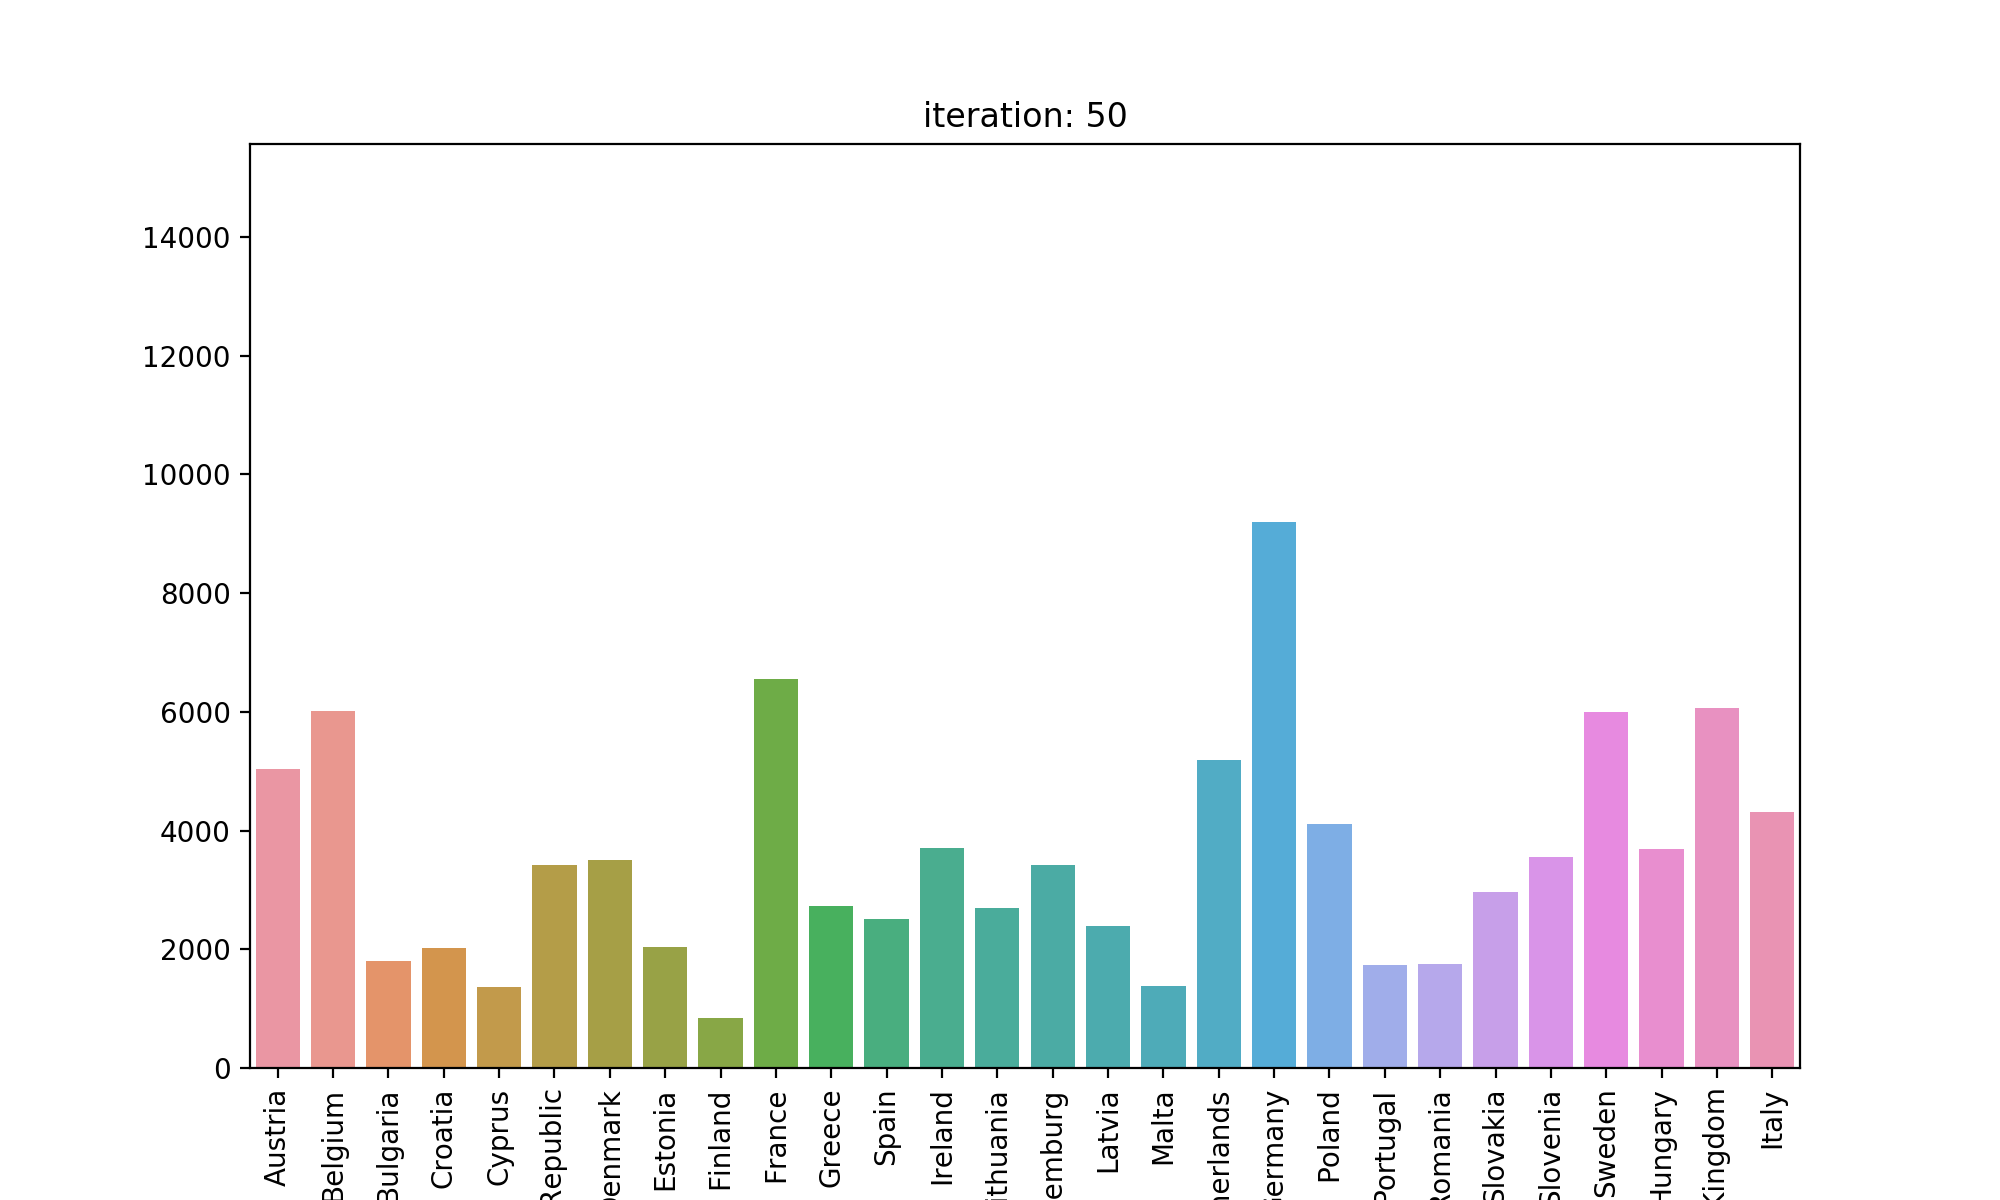

In [10]:
%matplotlib notebook
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

fig = plt.figure(figsize=(10,6))

def animate(i):
    fig.clear()
    plt.ylim(0, df_results.max().max())
    p = sns.barplot(x=df_results[i].fillna(0).index.values, y=df_results[i].fillna(0).values)
    p.set_title('iteration: {}'.format(i+1))
    for item in p.get_xticklabels():
        item.set_rotation(90)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=500, frames = n_iter, repeat=False)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
ani.save('results/agents_in_countries_in_each_step.mp4', writer=writer)

At the beginning of simulation we can observe some peaks on the chart for the countries with more population than in another countries (Germany, France, United Kingdom, Italy and Spain).<br>
Agents number in Germany and France are respectively still one of the greatest at the end of simulation.<br>
But for some countries (like Spain and Italy) number of agents had dramatically decreased. <br>

In subsequent iterations, number of agents in countries are more stable. We can still observe some migration but more of them had already found the best place for them.

#### Saving data in order to provide more detailed statistics

In [11]:
eu_map.current_country_collector.get_agent_vars_dataframe().to_csv('results/current_country.csv', sep=';', encoding='utf-8')
eu_map.race_collector.get_agent_vars_dataframe().to_csv('results/race.csv', sep=';', encoding='utf-8')
eu_map.religious_denomination_collector.get_agent_vars_dataframe().to_csv('results/religious_denomination.csv', sep=';', encoding='utf-8')